# Start work

In [ ]:
import pandas as pd
import zipfile
from datetime import datetime

### Load Data

In [ ]:
#load zip file
zf = zipfile.ZipFile('data.zip')

In [ ]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [ ]:
#load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


You can draw the wafers map to see how the wafers look like in the data.

Using the following helper function you can draw the wafer maps with or without labels:

In [ ]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')

    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
       # s = 2**17/(wafer_size)
        s = 17
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2))

        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        #ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)

        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            #ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            #ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    import numpy as np
    import matplotlib.pyplot as plt

    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Select the amount of samples you want to display:

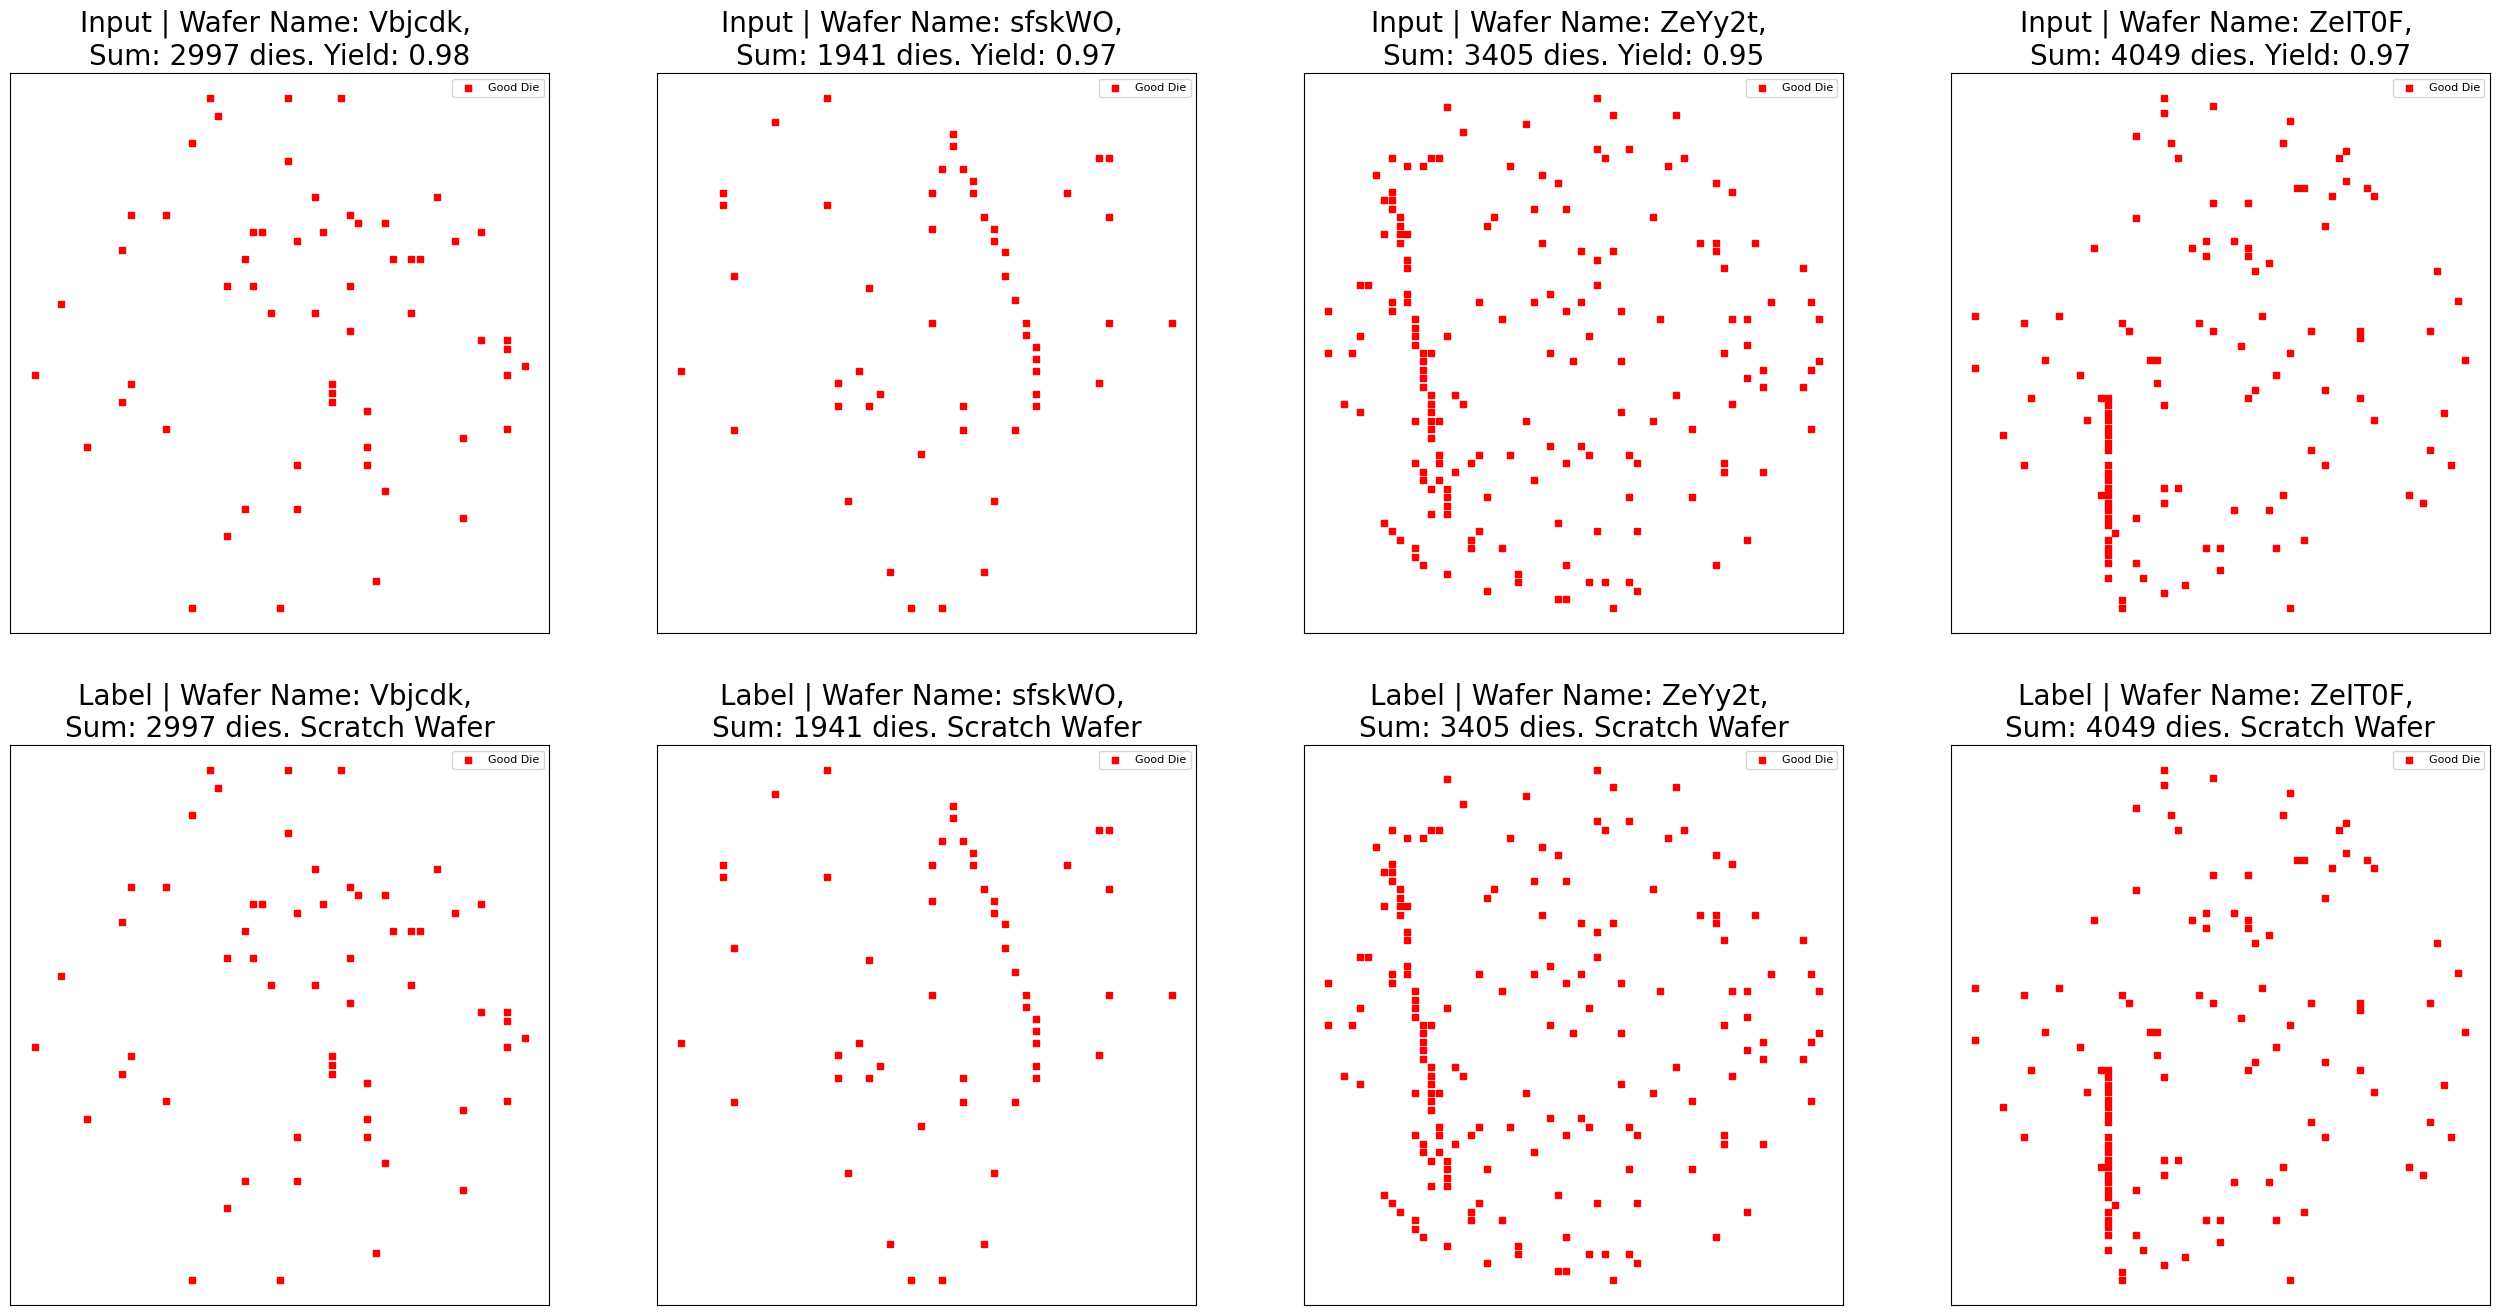

In [ ]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

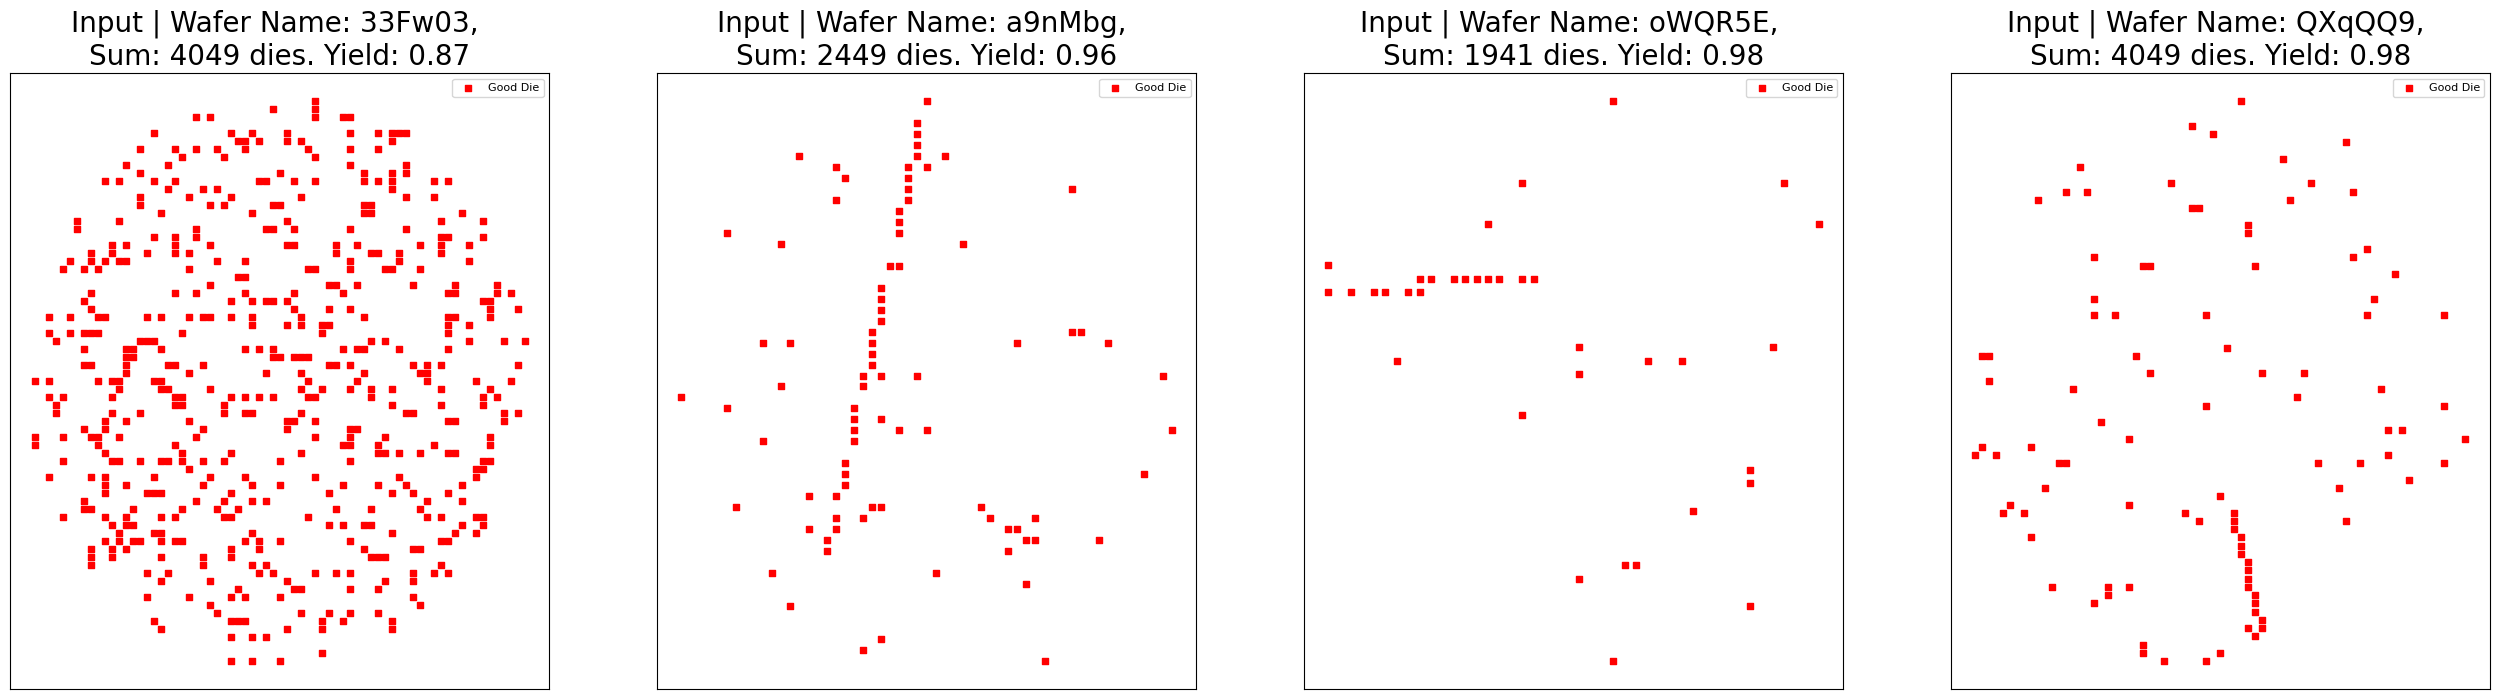

In [ ]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

### Step 1: Selecting a Specific Wafer to learn the data


In [ ]:
# Choose a specific wafer name from the dataset
wafer_name = '7vbLWL'  # You can replace this with any wafer name

# Extract only the rows related to the selected wafer
df_defects_copy = df_wafers[df_wafers['WaferName'] == wafer_name].copy()

# Print the number of rows and columns for this wafer
print(df_defects_copy.shape)

# Show the first few rows to confirm the selection
df_defects_copy.head()


(3405, 5)


,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
2054035,7vbLWL,0,24,True,False
2054036,7vbLWL,0,25,True,False
2054037,7vbLWL,0,26,True,False
2054038,7vbLWL,0,27,True,False
2054039,7vbLWL,0,28,True,False


### Step 2: Creating a Smaller Sample for Testing

In [ ]:
df_defects_copy = df_wafers.copy()

df_defects_small = df_wafers.copy().head(3405)

# בדיקה כמה Wafers יש לנו
print(df_defects_small['WaferName'].nunique())
print(df_defects_small['WaferName'].value_counts())



1
WaferName
8PFrAN    3405
Name: count, dtype: int64


### Step 3: Calculating Neighbor Features Using KDTree

We use a KDTree to efficiently calculate neighbor statistics for each die on the wafer.  
For a list of radius `[5, 6, 7, 8, 9]`, we calculate:

- `num_bad_neighbors_rX`: the number of bad neighbors within radius X  
- `perc_bad_neighbors_rX`: the percentage of bad neighbors within radius X  



In [ ]:
from sklearn.neighbors import KDTree
import pandas as pd
import numpy as np

# List of radii to check
radii = [5, 6, 7, 8, 9]

# Make a copy of the dataset to work on
df_multi_radius = df_defects_small.copy()

# Build KDTree for fast neighbor search based on coordinates
coords = df_multi_radius[['DieX', 'DieY']].values
tree = KDTree(coords, leaf_size=40)

# Loop through each radius and calculate features
for radius in radii:
    num_bad_neighbors = []
    perc_bad_neighbors = []

    for idx, row in df_multi_radius.iterrows():
        # Find indices of neighboring points within the given radius
        ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
        neighbors = df_multi_radius.iloc[ind]

        # Remove the current point itself from its neighbors
        neighbors = neighbors.drop(idx, errors='ignore')

        if len(neighbors) == 0:
            num_bad_neighbors.append(0)
            perc_bad_neighbors.append(0)
        else:
            # Count how many neighbors are bad
            num_bad = (neighbors['IsGoodDie'] == False).sum()
            num_bad_neighbors.append(num_bad)
            perc_bad = num_bad / len(neighbors)
            perc_bad_neighbors.append(perc_bad)

    # Add the new columns to the DataFrame
    df_multi_radius[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
    df_multi_radius[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors

# Show the updated DataFrame
df_multi_radius.head()


,WaferName,DieX,DieY,IsGoodDie,IsScratchDie,num_bad_neighbors_r5,perc_bad_neighbors_r5,num_bad_neighbors_r6,perc_bad_neighbors_r6,num_bad_neighbors_r7,perc_bad_neighbors_r7,num_bad_neighbors_r8,perc_bad_neighbors_r8,num_bad_neighbors_r9,perc_bad_neighbors_r9
0,8PFrAN,0,27,True,False,0,0.0,0,0.000000,1,0.014085,3,0.032258,4,0.033613
1,8PFrAN,0,28,True,False,0,0.0,0,0.000000,2,0.027397,4,0.041667,4,0.032787
2,8PFrAN,0,29,True,False,0,0.0,0,0.000000,2,0.026667,4,0.040816,4,0.032000
3,8PFrAN,0,30,True,False,0,0.0,0,0.000000,2,0.025974,4,0.040000,4,0.031496
4,8PFrAN,0,31,True,False,0,0.0,1,0.016667,2,0.025641,4,0.039216,4,0.031008


### Step 4: Filtering Scratch Points Only

Now that we’ve calculated the neighborhood features, we want to explore the dies that are part of a scratch.  
These are the points where the column `IsScratchDie` is `True`.  

In [ ]:
# Filter only the points that are labeled as part of a scratch
df_scratch_points = df_multi_radius[df_multi_radius['IsScratchDie'] == True]

# Show the first 1000 scratch points
df_scratch_points.head(1000)



,WaferName,DieX,DieY,IsGoodDie,IsScratchDie,num_bad_neighbors_r5,perc_bad_neighbors_r5,num_bad_neighbors_r6,perc_bad_neighbors_r6,num_bad_neighbors_r7,perc_bad_neighbors_r7,num_bad_neighbors_r8,perc_bad_neighbors_r8,num_bad_neighbors_r9,perc_bad_neighbors_r9
1541,8PFrAN,28,49,False,True,5,0.062500,8,0.071429,11,0.074324,13,0.066327,17,0.067460
1612,8PFrAN,29,49,False,True,7,0.087500,8,0.071429,12,0.081081,15,0.076531,18,0.071429
1682,8PFrAN,30,48,False,True,8,0.100000,12,0.107143,13,0.087838,15,0.076531,19,0.075397
1753,8PFrAN,31,48,True,True,11,0.137500,13,0.116071,15,0.101351,19,0.096939,22,0.087302
1824,8PFrAN,32,48,False,True,9,0.112500,13,0.116071,17,0.114865,20,0.102041,22,0.087302
1894,8PFrAN,33,47,False,True,11,0.137500,14,0.125000,19,0.128378,20,0.102041,23,0.091270
1965,8PFrAN,34,47,False,True,11,0.137500,15,0.133929,18,0.121622,21,0.107143,24,0.095238
2036,8PFrAN,35,47,False,True,11,0.137500,15,0.133929,17,0.114865,20,0.102041,26,0.103175
2106,8PFrAN,36,46,True,True,13,0.162500,15,0.133929,19,0.128378,23,0.117347,27,0.107143
2177,8PFrAN,37,46,False,True,12,0.150000,15,0.133929,20,0.135135,21,0.107143,24,0.095238


### Step 5: Building a Neural Network Classifier

After computing neighborhood features, we now train a basic neural network to classify whether a die is part of a scratch (`IsScratchDie`).

We'll use 10 radius-based features and the die quality indicator (`IsGoodDie`) as inputs.  
The model will be trained and evaluated using a train-test split with stratification.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix

# 1. Select input features and target
feature_cols = [
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5',
    'num_bad_neighbors_r6', 'perc_bad_neighbors_r6',
    'num_bad_neighbors_r7', 'perc_bad_neighbors_r7',
    'num_bad_neighbors_r8', 'perc_bad_neighbors_r8',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9',
    'IsGoodDie'
]

X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)  # Binary classification target

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Define a small feedforward neural network
model = Sequential([
    Dense(32, activation='relu', input_dim=len(feature_cols)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the model with validation split
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# 5. Predict and evaluate on test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 6. Print evaluation results
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3710 - loss: 0.9949 - val_accuracy: 0.9937 - val_loss: 0.1469
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9928 - loss: 0.1303 - val_accuracy: 0.9937 - val_loss: 0.0815
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9891 - loss: 0.1000 - val_accuracy: 0.9937 - val_loss: 0.0644
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9901 - loss: 0.0840 - val_accuracy: 0.9937 - val_loss: 0.0563
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0627 - val_accuracy: 0.9937 - val_loss: 0.0484
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9882 - loss: 0.0773 - val_accuracy: 0.9937 - val_loss: 0.0412
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9914 - loss: 0.0489 - val_accuracy: 0.9937 - val_loss: 0.0368
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9920 - loss: 0.0401 - val_accuracy: 0.9937 - val_loss: 0.0312
Epo

The classification report and confusion matrix show that the model performs very well in predicting the majority class (`0`, i.e., non-scratch points), with almost perfect accuracy and precision.

However, the model fails to predict any of the minority class (`1`, i.e., scratch points).


To better understand how the model learned over time, we plotted both the training and validation accuracy and loss across all epochs.


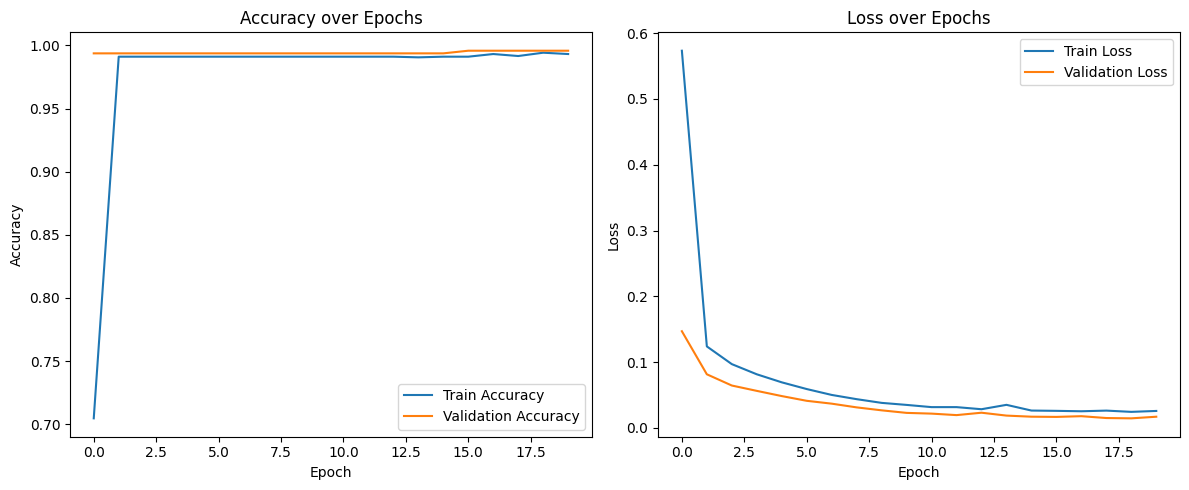

In [ ]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In this version, we updated the model from the previous version in three key ways:

Class Weights for Imbalanced Data

Larger Model Architecture (32 → 16 → 1) to (64 → 32 → 1)

More Training Epochs (from 20 → 30)

Class weights: {0: np.float64(0.5042319085907745), 1: np.float64(59.575)}
Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5285 - loss: 0.7724 - val_accuracy: 0.9344 - val_loss: 0.3339
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7289 - loss: 0.4466 - val_accuracy: 0.7524 - val_loss: 0.5205
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8217 - loss: 0.3279 - val_accuracy: 0.9922 - val_loss: 0.1010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8465 - loss: 0.3516 - val_accuracy: 0.8767 - val_loss: 0.3417
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9110 - loss: 0.1978 - val_accuracy: 0.9061 - val_loss: 0.2558
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7952 - loss: 0.3632 - val_accuracy: 0.9472 - val_loss: 0.1625
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8535 - loss: 0.3766 - val_accuracy: 0.9883 - val_loss: 0.0705
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

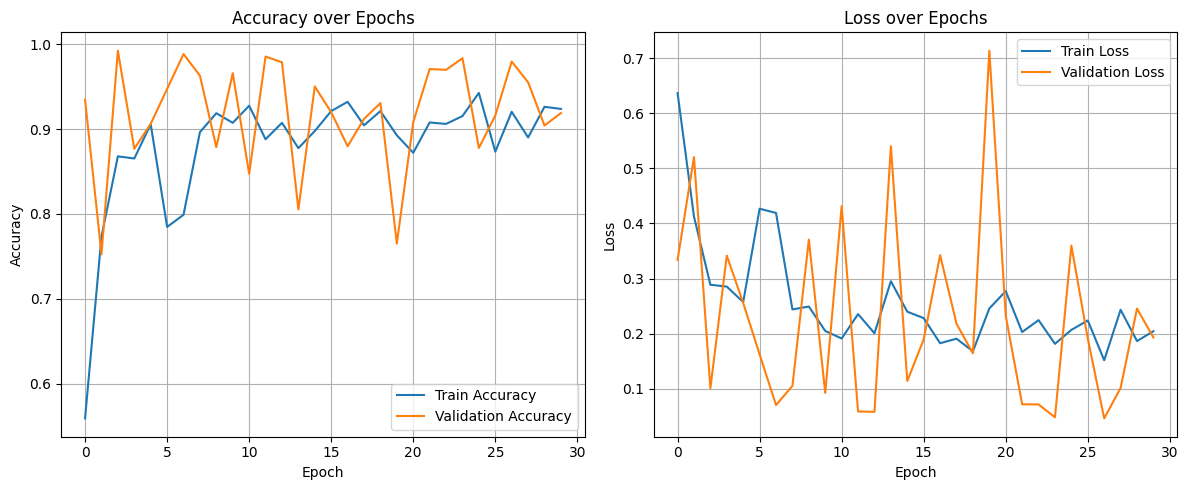

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1014
           1       0.09      1.00      0.16         8

    accuracy                           0.92      1022
   macro avg       0.54      0.96      0.56      1022
weighted avg       0.99      0.92      0.95      1022


Confusion Matrix:
[[931  83]
 [  0   8]]


In [ ]:
# === Import necessary libraries ===
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Select features and define the target ===
feature_cols = [
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5',
    'num_bad_neighbors_r6', 'perc_bad_neighbors_r6',
    'num_bad_neighbors_r7', 'perc_bad_neighbors_r7',
    'num_bad_neighbors_r8', 'perc_bad_neighbors_r8',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9',
    'IsGoodDie'
]

X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)  # Binary classification: 0 = no scratch, 1 = scratch

# === 2. Split into training and validation sets ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === 3. Handle class imbalance by computing class weights ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# === 4. Define the neural network model ===
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer based on number of features
    layers.Dense(64, activation='relu'),      # Hidden layer 1
    layers.Dense(32, activation='relu'),      # Hidden layer 2
    layers.Dense(1, activation='sigmoid')     # Output layer for binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === 5. Train the model ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,  # Apply class weights
    verbose=1
)

# === 6. Plot training and validation accuracy and loss ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === 7. Evaluate model performance on validation set ===
y_pred = (model.predict(X_val) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


The model successfully identified all actual scratch points (recall = 1.00) but did so with low precision (0.07), meaning most predicted scratches were false positives. While overall accuracy was high (90%), this is mainly due to the dominance of non-scratch points in the dataset. The results indicate that the model is highly sensitive to scratches

#Step 7 :Test the model on several wafers

Using 7 wafers with 24811 total points.
Updated dataset shape after feature generation: (24811, 15)
Class weights: {0: np.float64(0.5030996523754345), 1: np.float64(81.15420560747664)}
Epoch 1/20
543/543 - 3s - 6ms/step - accuracy: 0.8573 - loss: 0.3403 - val_accuracy: 0.9041 - val_loss: 0.2676
Epoch 2/20
543/543 - 2s - 3ms/step - accuracy: 0.9143 - loss: 0.1948 - val_accuracy: 0.9357 - val_loss: 0.1818
Epoch 3/20
543/543 - 3s - 5ms/step - accuracy: 0.9094 - loss: 0.2216 - val_accuracy: 0.7817 - val_loss: 0.6883
Epoch 4/20
543/543 - 3s - 5ms/step - accuracy: 0.9043 - loss: 0.2171 - val_accuracy: 0.9383 - val_loss: 0.1526
Epoch 5/20
543/543 - 2s - 4ms/step - accuracy: 0.9303 - loss: 0.1593 - val_accuracy: 0.8180 - val_loss: 0.5474
Epoch 6/20
543/543 - 3s - 5ms/step - accuracy: 0.9144 - loss: 0.1903 - val_accuracy: 0.9508 - val_loss: 0.1164
Epoch 7/20
543/543 - 1s - 2ms/step - accuracy: 0.9269 - loss: 0.1584 - val_accuracy: 0.9766 - val_loss: 0.0504
Epoch 8/20
543/543 - 2s - 3ms/step - a

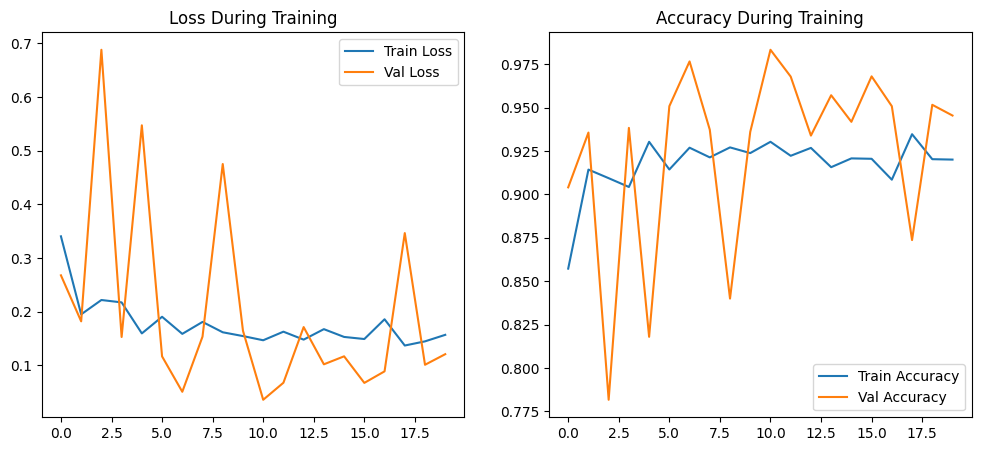

In [ ]:

from sklearn.neighbors import KDTree
from sklearn.utils import class_weight
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Step 1: Select Specific Wafers ---
# Filter the dataset to include only a predefined list of wafers for training
selected_wafers = ['8PFrAN', 'ZeYy2t', '7vbLWL', 'Ha3TvN', '4PkSaF', '9BJt1r', 'zlgMGB']
df_selected = df_wafers[df_wafers['WaferName'].isin(selected_wafers)].copy()
print(f"Using {df_selected['WaferName'].nunique()} wafers with {len(df_selected)} total points.")

# --- Step 2: Calculate Neighbor Features using KDTree ---
# For each wafer separately, calculate neighbor statistics within several radii
radii = [5, 6, 7, 8, 9]
all_results = []

for wafer_name, wafer_df in df_selected.groupby('WaferName'):
    coords = wafer_df[['DieX', 'DieY']].values
    tree = KDTree(coords, leaf_size=40)

    for radius in radii:
        num_bad_neighbors = []
        perc_bad_neighbors = []

        for idx, row in wafer_df.iterrows():
            ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
            neighbors = wafer_df.iloc[ind].drop(idx, errors='ignore')

            if len(neighbors) == 0:
                num_bad_neighbors.append(0)
                perc_bad_neighbors.append(0)
            else:
                num_bad = (neighbors['IsGoodDie'] == False).sum()
                num_bad_neighbors.append(num_bad)
                perc_bad_neighbors.append(num_bad / len(neighbors))

        wafer_df[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
        wafer_df[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors

    all_results.append(wafer_df)

df_multi_radius = pd.concat(all_results)
print(f"Updated dataset shape after feature generation: {df_multi_radius.shape}")

# --- Step 3: Feature Selection ---
feature_cols = [
    'IsGoodDie',
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5',
    'num_bad_neighbors_r6', 'perc_bad_neighbors_r6',
    'num_bad_neighbors_r7', 'perc_bad_neighbors_r7',
    'num_bad_neighbors_r8', 'perc_bad_neighbors_r8',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9'
]
X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)

# --- Step 4: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Step 5: Compute Class Weights ---
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print(f"Class weights: {class_weights}")

# --- Step 6: Build Neural Network ---
model = models.Sequential([
    layers.Input(shape=(len(feature_cols),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Step 7: Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    verbose=2
)

# --- Step 8: Evaluation ---
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- Step 9: Plot Training Metrics ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy During Training')
plt.legend()
plt.show()


The model achieved 97% overall accuracy, with a very high recall of 89% for the minority class (scratch points), indicating strong sensitivity in detecting scratches. However, the precision for scratches is low (17%), meaning many of the positive predictions were false alarms.

In this **model**, we reduced the number of neighbor-checking radii for each point and limited the analysis to two specific radii, in order to define a focused range for evaluating neighboring points.

Using 7 wafers with 24811 total points.
Updated dataset shape after feature generation: (24811, 9)
Class weights: {0: np.float64(0.5030996523754345), 1: np.float64(81.15420560747664)}
Epoch 1/20
543/543 - 4s - 7ms/step - accuracy: 0.9194 - loss: 0.3102 - val_accuracy: 0.9590 - val_loss: 0.1063
Epoch 2/20
543/543 - 2s - 3ms/step - accuracy: 0.9350 - loss: 0.1596 - val_accuracy: 0.9395 - val_loss: 0.1663
Epoch 3/20
543/543 - 3s - 5ms/step - accuracy: 0.9258 - loss: 0.1640 - val_accuracy: 0.9612 - val_loss: 0.0837
Epoch 4/20
543/543 - 2s - 3ms/step - accuracy: 0.9338 - loss: 0.1712 - val_accuracy: 0.9359 - val_loss: 0.1736
Epoch 5/20
543/543 - 2s - 3ms/step - accuracy: 0.9317 - loss: 0.1506 - val_accuracy: 0.9272 - val_loss: 0.1993
Epoch 6/20
543/543 - 3s - 6ms/step - accuracy: 0.9342 - loss: 0.1535 - val_accuracy: 0.9061 - val_loss: 0.3104
Epoch 7/20
543/543 - 2s - 3ms/step - accuracy: 0.9288 - loss: 0.1598 - val_accuracy: 0.9115 - val_loss: 0.2356
Epoch 8/20
543/543 - 3s - 5ms/step - ac

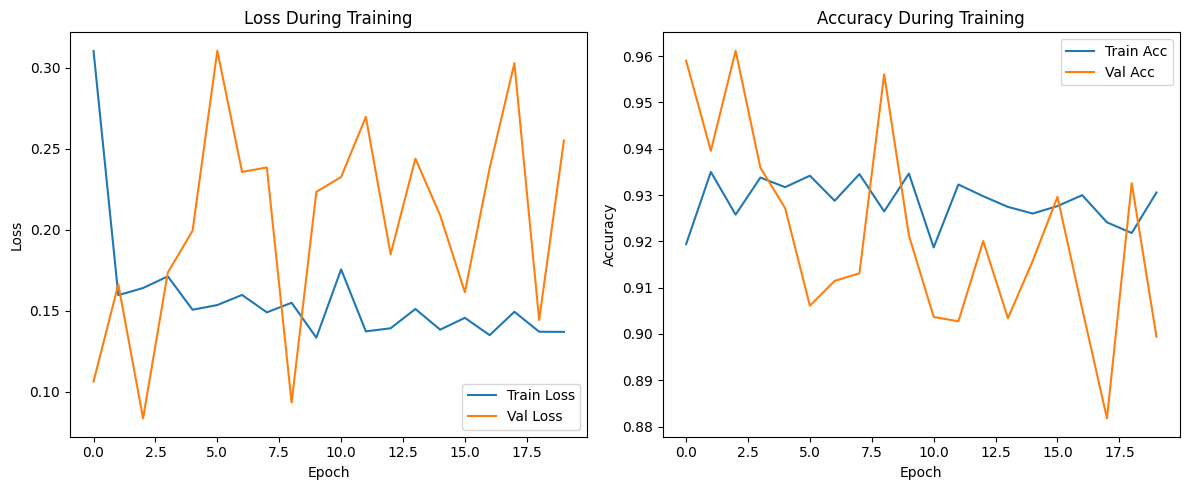

In [ ]:
# Importing required libraries
from sklearn.neighbors import KDTree
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# =========================
# 1. Select specific wafers to analyze
# =========================

# Filtering the dataset to include only selected wafers
selected_wafers = ['8PFrAN', 'ZeYy2t', '7vbLWL', 'Ha3TvN', '4PkSaF', '9BJt1r', 'zlgMGB']
df_selected = df_wafers[df_wafers['WaferName'].isin(selected_wafers)].copy()

print(f"Using {df_selected['WaferName'].nunique()} wafers with {len(df_selected)} total points.")

# =========================
# 2. Compute neighbor-based features
# =========================

# Define the radii we want to analyze for neighbors
radii = [5, 9] #This is the change!
all_results = []

# For each wafer, build a KDTree and compute features
for wafer_name, wafer_df in df_selected.groupby('WaferName'):
    coords = wafer_df[['DieX', 'DieY']].values
    tree = KDTree(coords, leaf_size=40)

    for radius in radii:
        num_bad_neighbors = []
        perc_bad_neighbors = []

        for idx, row in wafer_df.iterrows():
            ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
            neighbors = wafer_df.iloc[ind]
            neighbors = neighbors.drop(idx, errors='ignore')

            if len(neighbors) == 0:
                num_bad_neighbors.append(0)
                perc_bad_neighbors.append(0)
            else:
                num_bad = (neighbors['IsGoodDie'] == False).sum()
                num_bad_neighbors.append(num_bad)
                perc_bad = num_bad / len(neighbors)
                perc_bad_neighbors.append(perc_bad)

        wafer_df[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
        wafer_df[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors

    all_results.append(wafer_df)

# Combine all wafers into one DataFrame
df_multi_radius = pd.concat(all_results)
print(f"Updated dataset shape after feature generation: {df_multi_radius.shape}")

# =========================
# 3. Select features and label
# =========================

feature_cols = [
    'IsGoodDie',
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9'
]

X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)

# =========================
# 4. Split into training and testing sets
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# =========================
# 5. Compute class weights to handle imbalance
# =========================

weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train),
                                             y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print(f"Class weights: {class_weights}")

# =========================
# 6. Build a neural network model
# =========================

model = models.Sequential([
    layers.Input(shape=(len(feature_cols),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# =========================
# 7. Train the model
# =========================

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    verbose=2
)

# =========================
# 8. Evaluate performance
# =========================

y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# =========================
# 9. Plot training performance
# =========================

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In this model, we observe a high recall for the minority class (1.00), meaning nearly all scratch points were detected. However, the precision is extremely low (0.03), indicating a large number of false positives. The overall accuracy dropped to 79%, and while the model successfully detects defects, it does so at the cost of misclassifying many normal point

#Step 8:
Try training the model on a larger number of wafers by selecting a bigger portion of the dataset — for example, choosing a specific percentage of the total rows

Using 40 wafers with 104016 total points.
Updated dataset shape after feature generation: (104016, 9)
Class weights: {0: np.float64(0.5035478159838447), 1: np.float64(70.96588693957115)}
Epoch 1/20
2276/2276 - 8s - 3ms/step - accuracy: 0.9180 - loss: 0.1905 - val_accuracy: 0.9392 - val_loss: 0.1452
Epoch 2/20
2276/2276 - 10s - 4ms/step - accuracy: 0.9361 - loss: 0.1435 - val_accuracy: 0.9415 - val_loss: 0.1408
Epoch 3/20
2276/2276 - 10s - 5ms/step - accuracy: 0.9332 - loss: 0.1452 - val_accuracy: 0.9416 - val_loss: 0.1333
Epoch 4/20
2276/2276 - 9s - 4ms/step - accuracy: 0.9365 - loss: 0.1356 - val_accuracy: 0.9378 - val_loss: 0.1495
Epoch 5/20
2276/2276 - 13s - 6ms/step - accuracy: 0.9280 - loss: 0.1412 - val_accuracy: 0.9291 - val_loss: 0.1575
Epoch 6/20
2276/2276 - 7s - 3ms/step - accuracy: 0.9342 - loss: 0.1320 - val_accuracy: 0.9649 - val_loss: 0.0683
Epoch 7/20
2276/2276 - 10s - 5ms/step - accuracy: 0.9334 - loss: 0.1318 - val_accuracy: 0.9346 - val_loss: 0.1532
Epoch 8/20
2276/22

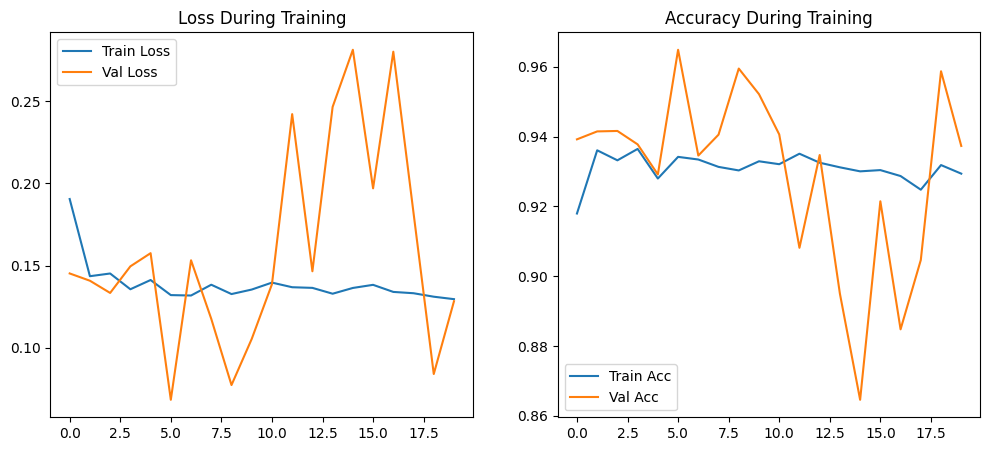

In [ ]:
# Here is the change we select a specific number of rows from the data set
df_selected = df_wafers.iloc[:104016].copy()

print(f"Using {df_selected['WaferName'].nunique()} wafers with {len(df_selected)} total points.")

radii = [5, 9]
all_results = []

for wafer_name, wafer_df in df_selected.groupby('WaferName'):
    coords = wafer_df[['DieX', 'DieY']].values
    tree = KDTree(coords, leaf_size=40)

    for radius in radii:
        num_bad_neighbors = []
        perc_bad_neighbors = []

        for idx, row in wafer_df.iterrows():
            ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
            neighbors = wafer_df.iloc[ind]
            neighbors = neighbors.drop(idx, errors='ignore')

            if len(neighbors) == 0:
                num_bad_neighbors.append(0)
                perc_bad_neighbors.append(0)
            else:
                num_bad = (neighbors['IsGoodDie'] == False).sum()
                num_bad_neighbors.append(num_bad)
                perc_bad = num_bad / len(neighbors)
                perc_bad_neighbors.append(perc_bad)

        wafer_df[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
        wafer_df[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors

    all_results.append(wafer_df)

df_multi_radius = pd.concat(all_results)
print(f"Updated dataset shape after feature generation: {df_multi_radius.shape}")


feature_cols = [
    'IsGoodDie',
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9'
]

X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)



weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train),
                                             y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print(f"Class weights: {class_weights}")



model = models.Sequential([
    layers.Input(shape=(len(feature_cols),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    verbose=2
)



y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy During Training')
plt.legend()

plt.show()


The model trained on 40 wafers (104,016 points) achieved 95% overall accuracy, with a strong recall of 91% for class 1 (scratched dies). Although the precision for class 1 remains low at 12%, the model is effective at detecting most actual scratched instances. The macro average F1-score is 0.60, indicating an improved balance compared to previous runs

#Step 9: Add the coordinates of each point (DieX, DieY) as features to try and improve the model's accuracy and increase the amount of data.

Using 414 wafers with 1005770 total points.
Updated dataset shape after feature generation: (104016, 11)
Class weights: {0: np.float64(0.5035478159838447), 1: np.float64(70.96588693957115)}
Epoch 1/30
2276/2276 - 9s - 4ms/step - accuracy: 0.8696 - loss: 0.3634 - val_accuracy: 0.9662 - val_loss: 0.0902
Epoch 2/30
2276/2276 - 10s - 4ms/step - accuracy: 0.9269 - loss: 0.1924 - val_accuracy: 0.9376 - val_loss: 0.1692
Epoch 3/30
2276/2276 - 8s - 4ms/step - accuracy: 0.9303 - loss: 0.1927 - val_accuracy: 0.9368 - val_loss: 0.1776
Epoch 4/30
2276/2276 - 7s - 3ms/step - accuracy: 0.9315 - loss: 0.1712 - val_accuracy: 0.9684 - val_loss: 0.0783
Epoch 5/30
2276/2276 - 7s - 3ms/step - accuracy: 0.9278 - loss: 0.1771 - val_accuracy: 0.9564 - val_loss: 0.0994
Epoch 6/30
2276/2276 - 10s - 4ms/step - accuracy: 0.9351 - loss: 0.1543 - val_accuracy: 0.9522 - val_loss: 0.1122
Epoch 7/30
2276/2276 - 12s - 5ms/step - accuracy: 0.9342 - loss: 0.1535 - val_accuracy: 0.9502 - val_loss: 0.1213
Epoch 8/30
2276/

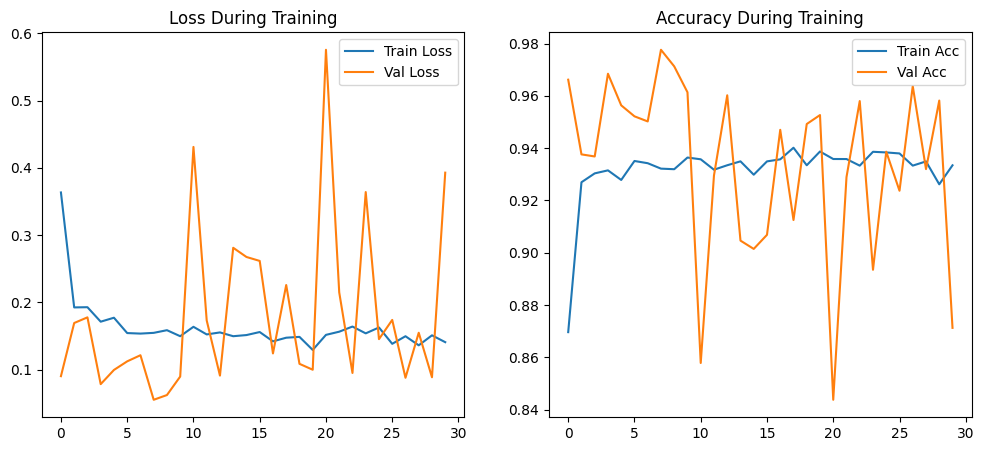

In [ ]:
import tensorflow as tf


df_selected = df_wafers.iloc[:1005770].copy()#more data to fit

print(f"Using {df_selected['WaferName'].nunique()} wafers with {len(df_selected)} total points.")

radii = [5, 9]
all_results = []

for wafer_name, wafer_df in df_wafers.iloc[:104016].groupby('WaferName'):
    coords = wafer_df[['DieX', 'DieY']].values
    tree = KDTree(coords, leaf_size=40)

    for radius in radii:
        num_bad_neighbors = []
        perc_bad_neighbors = []
        total_neighbors = []

        for idx, row in wafer_df.iterrows():
            ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
            neighbors = wafer_df.iloc[ind]
            neighbors = neighbors.drop(idx, errors='ignore')

            total = len(neighbors)
            total_neighbors.append(total)

            if total == 0:
                num_bad_neighbors.append(0)
                perc_bad_neighbors.append(0)
            else:
                num_bad = (neighbors['IsGoodDie'] == False).sum()
                num_bad_neighbors.append(num_bad)
                perc_bad_neighbors.append(num_bad / total)

        wafer_df[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
        wafer_df[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors
        wafer_df[f'total_neighbors_r{radius}'] = total_neighbors

    all_results.append(wafer_df)

df_multi_radius = pd.concat(all_results)
print(f"Updated dataset shape after feature generation: {df_multi_radius.shape}")



feature_cols = [
    'IsGoodDie',
    'DieX', 'DieY',  # << We added here the coordinates
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9'
]

X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)



weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train),
                                             y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print(f"Class weights: {class_weights}")



model = models.Sequential([
    layers.Input(shape=(len(feature_cols),)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    verbose=2
)



y_pred = (model.predict(X_test) > 0.7).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy During Training')
plt.legend()

plt.show()


The model trained on 414 wafers using both neighbor-based features and the die coordinates achieved an overall accuracy of 92%. While the recall for the minority class (scratch = 1) was very high (97%), the precision remained low (8%), indicating a high number of false positives. Still, the model successfully detected most of the actual scratches

#Step 10: Try applying sin and cos transformations to the point coordinates to see if this improves the model's performance and add to the data the num of neighbors for each point.

Class weights: {0: np.float64(0.5040789469915886), 1: np.float64(61.790328242934876)}
Epoch 1/30
22002/22002 - 64s - 3ms/step - accuracy: 0.8793 - loss: 0.3483 - val_accuracy: 0.9322 - val_loss: 0.1213
Epoch 2/30
22002/22002 - 79s - 4ms/step - accuracy: 0.9167 - loss: 0.1723 - val_accuracy: 0.9480 - val_loss: 0.0812
Epoch 3/30
22002/22002 - 65s - 3ms/step - accuracy: 0.9141 - loss: 0.1656 - val_accuracy: 0.9936 - val_loss: 0.0192
Epoch 4/30
22002/22002 - 66s - 3ms/step - accuracy: 0.9099 - loss: 0.1616 - val_accuracy: 0.9449 - val_loss: 0.0867
Epoch 5/30
22002/22002 - 59s - 3ms/step - accuracy: 0.9121 - loss: 0.1598 - val_accuracy: 0.9192 - val_loss: 0.1309
Epoch 6/30
22002/22002 - 60s - 3ms/step - accuracy: 0.9155 - loss: 0.1551 - val_accuracy: 0.9163 - val_loss: 0.1213
Epoch 7/30
22002/22002 - 62s - 3ms/step - accuracy: 0.9151 - loss: 0.1564 - val_accuracy: 0.9398 - val_loss: 0.1315
Epoch 8/30
22002/22002 - 63s - 3ms/step - accuracy: 0.9158 - loss: 0.1542 - val_accuracy: 0.8910 - val

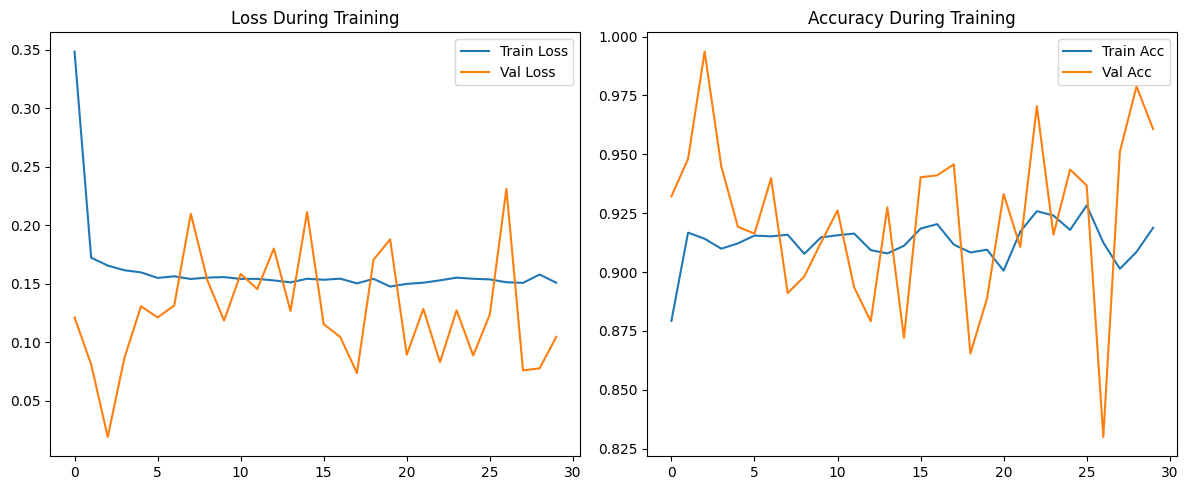

In [ ]:

radii = [5, 9]
df_selected = df_wafers.iloc[:1005770].copy()
all_results = []

for wafer_name, wafer_df in df_selected.groupby('WaferName'):
    coords = wafer_df[['DieX', 'DieY']].values
    tree = KDTree(coords, leaf_size=40)

    for radius in radii:
        num_bad_neighbors = []
        perc_bad_neighbors = []
        total_neighbors = []

        for idx, row in wafer_df.iterrows():
            ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
            neighbors = wafer_df.iloc[ind]
            neighbors = neighbors.drop(idx, errors='ignore')

            total = len(neighbors)
            total_neighbors.append(total)

            if total == 0:
                num_bad_neighbors.append(0)
                perc_bad_neighbors.append(0)
            else:
                num_bad = (neighbors['IsGoodDie'] == False).sum()
                num_bad_neighbors.append(num_bad)
                perc_bad_neighbors.append(num_bad / total)

        wafer_df[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
        wafer_df[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors
        wafer_df[f'total_neighbors_r{radius}'] = total_neighbors#Adding a column for the number of neighbors.

    all_results.append(wafer_df)

df_multi_radius = pd.concat(all_results)

max_die_x = df_multi_radius['DieX'].max()
max_die_y = df_multi_radius['DieY'].max()


#Using Sin and Cos on X & Y
df_multi_radius['DieX_sin'] = np.sin(2 * np.pi * df_multi_radius['DieX'] / max_die_x)
df_multi_radius['DieX_cos'] = np.cos(2 * np.pi * df_multi_radius['DieX'] / max_die_x)
df_multi_radius['DieY_sin'] = np.sin(2 * np.pi * df_multi_radius['DieY'] / max_die_y)
df_multi_radius['DieY_cos'] = np.cos(2 * np.pi * df_multi_radius['DieY'] / max_die_y)

feature_cols = [
    'IsGoodDie',
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5', 'total_neighbors_r5',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9', 'total_neighbors_r9',
    'DieX_sin', 'DieX_cos', 'DieY_sin', 'DieY_cos'
]

X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train),
                                             y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print(f"Class weights: {class_weights}")

model = models.Sequential([
    layers.Input(shape=(len(feature_cols),)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    verbose=2
)

y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy During Training')
plt.legend()

plt.tight_layout()
plt.show()


The results show that the model achieves a very high overall accuracy of 95%, with strong performance on the majority class (IsScratchDie = 0) — reaching a precision of 1.00 and a recall of 0.95. However, while the model successfully identified most positive cases (recall = 0.95 for class 1), the precision for class 1 is low (0.13), meaning it produced a significant number of false positive

#Try to imporve the current model

Class weights: {0: np.float64(0.5040789469915886), 1: np.float64(61.790328242934876)}
Epoch 1/30
22002/22002 - 68s - 3ms/step - accuracy: 0.9310 - loss: 0.1320 - val_accuracy: 0.9425 - val_loss: 0.1040
Epoch 2/30
22002/22002 - 81s - 4ms/step - accuracy: 0.9252 - loss: 0.1234 - val_accuracy: 0.9065 - val_loss: 0.1478
Epoch 3/30
22002/22002 - 82s - 4ms/step - accuracy: 0.9269 - loss: 0.1206 - val_accuracy: 0.9150 - val_loss: 0.1439
Epoch 4/30
22002/22002 - 58s - 3ms/step - accuracy: 0.9213 - loss: 0.1208 - val_accuracy: 0.9285 - val_loss: 0.1143
Epoch 5/30
22002/22002 - 89s - 4ms/step - accuracy: 0.9209 - loss: 0.1238 - val_accuracy: 0.9333 - val_loss: 0.1136
Epoch 6/30
22002/22002 - 58s - 3ms/step - accuracy: 0.9201 - loss: 0.1223 - val_accuracy: 0.9270 - val_loss: 0.1171
Epoch 7/30
22002/22002 - 89s - 4ms/step - accuracy: 0.9210 - loss: 0.1215 - val_accuracy: 0.9156 - val_loss: 0.1416
Epoch 8/30
22002/22002 - 76s - 3ms/step - accuracy: 0.9192 - loss: 0.1244 - val_accuracy: 0.9173 - val

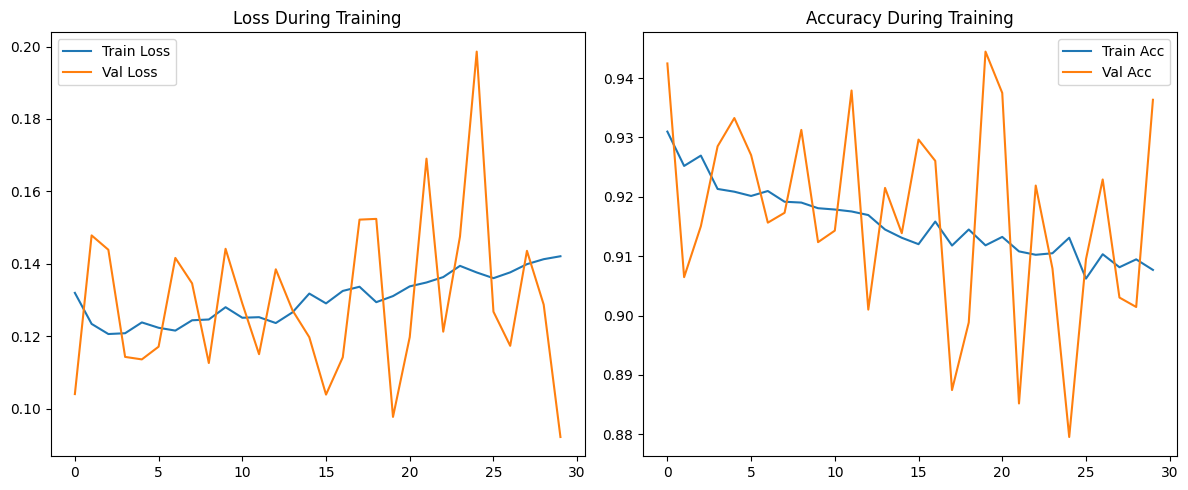

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

radii = [5, 10]#Change the radio
df_selected = df_wafers.iloc[:1005770].copy()
all_results = []

for wafer_name, wafer_df in df_selected.groupby('WaferName'):
    coords = wafer_df[['DieX', 'DieY']].values
    tree = KDTree(coords, leaf_size=40)

    for radius in radii:
        num_bad_neighbors = []
        perc_bad_neighbors = []
        total_neighbors = []

        for idx, row in wafer_df.iterrows():
            ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
            neighbors = wafer_df.iloc[ind]
            neighbors = neighbors.drop(idx, errors='ignore')

            total = len(neighbors)
            total_neighbors.append(total)

            if total == 0:
                num_bad_neighbors.append(0)
                perc_bad_neighbors.append(0)
            else:
                num_bad = (neighbors['IsGoodDie'] == False).sum()
                num_bad_neighbors.append(num_bad)
                perc_bad_neighbors.append(num_bad / total)

        wafer_df[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
        wafer_df[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors
        wafer_df[f'total_neighbors_r{radius}'] = total_neighbors

    all_results.append(wafer_df)

df_multi_radius = pd.concat(all_results)

max_die_x = df_multi_radius['DieX'].max()
max_die_y = df_multi_radius['DieY'].max()

df_multi_radius['DieX_sin'] = np.sin(2 * np.pi * df_multi_radius['DieX'] / max_die_x)
df_multi_radius['DieX_cos'] = np.cos(2 * np.pi * df_multi_radius['DieX'] / max_die_x)
df_multi_radius['DieY_sin'] = np.sin(2 * np.pi * df_multi_radius['DieY'] / max_die_y)
df_multi_radius['DieY_cos'] = np.cos(2 * np.pi * df_multi_radius['DieY'] / max_die_y)

feature_cols = [
    'IsGoodDie',
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5', 'total_neighbors_r5',
    'num_bad_neighbors_r10', 'perc_bad_neighbors_r10', 'total_neighbors_r10',
    'DieX_sin', 'DieX_cos', 'DieY_sin', 'DieY_cos'
]

X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train),
                                             y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print(f"Class weights: {class_weights}")

model = models.Sequential([
    layers.Input(shape=(len(feature_cols),)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    verbose=2
)

y_pred = (model.predict(X_test) > 0.7).astype(int)#Change from 0.5 -> 0.7 to see if there is any improvment

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy During Training')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# y_test: אמת
# y_pred: תחזיות בינאריות (כבר קיימות)
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall accuracy on test set: {accuracy:.4f} ({accuracy * 100:.2f}%)")


Overall accuracy on test set: 0.9053 (90.53%)


In [ ]:
from sklearn.metrics import confusion_matrix

# קבלת ערכים ממטריצת בלבול
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# דיוק ב-class 0 (True Negatives מתוך כלל המחלקה 0)
class_0_accuracy = tn / (tn + fp)

# דיוק ב-class 1 (True Positives מתוך כלל המחלקה 1)
class_1_accuracy = tp / (tp + fn)

print(f"Accuracy on Class 0 (Non-scratch): {class_0_accuracy:.4f} ({class_0_accuracy*100:.2f}%)")
print(f"Accuracy on Class 1 (Scratch):      {class_1_accuracy:.4f} ({class_1_accuracy*100:.2f}%)")


Accuracy on Class 0 (Non-scratch): 0.9047 (90.47%)
Accuracy on Class 1 (Scratch):      0.9846 (98.46%)


This model achieved very high overall accuracy of 99%, with a precision of 34% and recall of 85% for the minority class (IsScratchDie = 1). This indicates that while the model still produces false positives, it is significantly better at detecting true scratch defects compared to previous iterations.

Train the full Data set

Using 2125 wafers with 5262254 total points.
Class weights: {0: np.float64(0.503925709209137), 1: np.float64(64.18276066350711)}
Epoch 1/30
115112/115112 - 315s - 3ms/step - accuracy: 0.9242 - loss: 0.1299 - val_accuracy: 0.9281 - val_loss: 0.1293
Epoch 2/30
115112/115112 - 325s - 3ms/step - accuracy: 0.9171 - loss: 0.1312 - val_accuracy: 0.9471 - val_loss: 0.1036
Epoch 3/30
115112/115112 - 314s - 3ms/step - accuracy: 0.9151 - loss: 0.1358 - val_accuracy: 0.9086 - val_loss: 0.1566
Epoch 4/30
115112/115112 - 311s - 3ms/step - accuracy: 0.9096 - loss: 0.1410 - val_accuracy: 0.9126 - val_loss: 0.1296
Epoch 5/30
115112/115112 - 332s - 3ms/step - accuracy: 0.9074 - loss: 0.1447 - val_accuracy: 0.9119 - val_loss: 0.1362
Epoch 6/30
115112/115112 - 316s - 3ms/step - accuracy: 0.9056 - loss: 0.1508 - val_accuracy: 0.9252 - val_loss: 0.1284
Epoch 7/30
115112/115112 - 335s - 3ms/step - accuracy: 0.9023 - loss: 0.1536 - val_accuracy: 0.9295 - val_loss: 0.1022
Epoch 8/30
115112/115112 - 375s - 3ms/

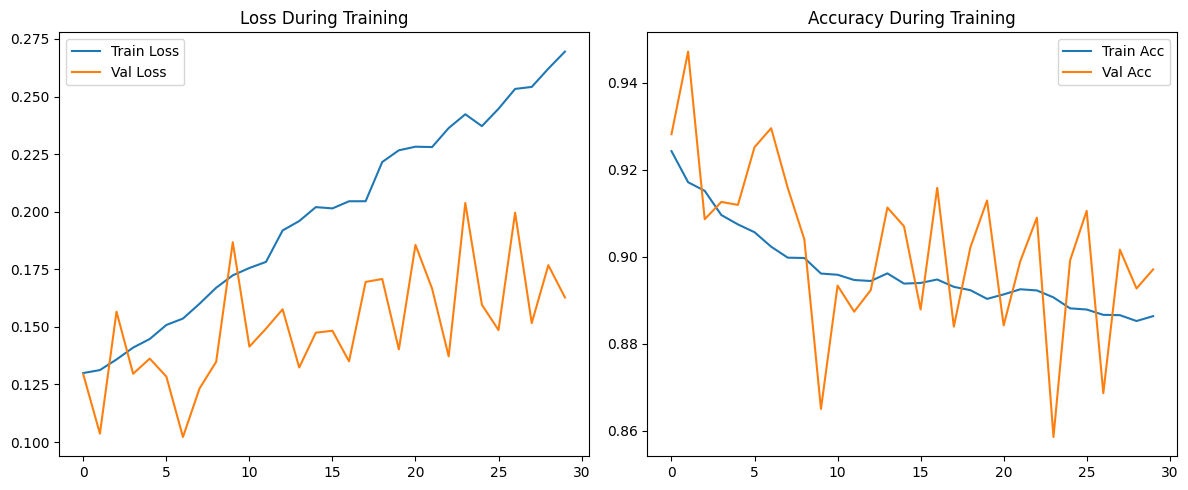

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models

radii = [5, 9]
df_selected = df_wafers.iloc[:5262254].copy()


print(f"Using {df_selected['WaferName'].nunique()} wafers with {len(df_selected)} total points.")

all_results = []

for wafer_name, wafer_df in df_selected.groupby('WaferName'):
    coords = wafer_df[['DieX', 'DieY']].values
    tree = KDTree(coords, leaf_size=40)

    for radius in radii:
        num_bad_neighbors = []
        perc_bad_neighbors = []
        total_neighbors = []

        for idx, row in wafer_df.iterrows():
            ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
            neighbors = wafer_df.iloc[ind]
            neighbors = neighbors.drop(idx, errors='ignore')

            total = len(neighbors)
            total_neighbors.append(total)

            if total == 0:
                num_bad_neighbors.append(0)
                perc_bad_neighbors.append(0)
            else:
                num_bad = (neighbors['IsGoodDie'] == False).sum()
                num_bad_neighbors.append(num_bad)
                perc_bad_neighbors.append(num_bad / total)

        wafer_df[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
        wafer_df[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors
        wafer_df[f'total_neighbors_r{radius}'] = total_neighbors

    all_results.append(wafer_df)

df_multi_radius = pd.concat(all_results)

max_die_x = df_multi_radius['DieX'].max()
max_die_y = df_multi_radius['DieY'].max()

df_multi_radius['DieX_sin'] = np.sin(2 * np.pi * df_multi_radius['DieX'] / max_die_x)
df_multi_radius['DieX_cos'] = np.cos(2 * np.pi * df_multi_radius['DieX'] / max_die_x)
df_multi_radius['DieY_sin'] = np.sin(2 * np.pi * df_multi_radius['DieY'] / max_die_y)
df_multi_radius['DieY_cos'] = np.cos(2 * np.pi * df_multi_radius['DieY'] / max_die_y)

feature_cols = [
    'IsGoodDie',
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5', 'total_neighbors_r5',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9', 'total_neighbors_r9',
    'DieX_sin', 'DieX_cos', 'DieY_sin', 'DieY_cos'
]

X = df_multi_radius[feature_cols]
y = df_multi_radius['IsScratchDie'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train),
                                             y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print(f"Class weights: {class_weights}")

model = models.Sequential([
    layers.Input(shape=(len(feature_cols),)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    verbose=2
)

y_pred = (model.predict(X_test) > 0.7).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy During Training')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from datetime import datetime
from sklearn.neighbors import KDTree
import numpy as np
import pandas as pd

# -------- שלב 1: חישוב פיצ'רים על df_wafers_test --------
test_results = []
for wafer_name, wafer_df in df_wafers_test.groupby('WaferName'):
    coords = wafer_df[['DieX', 'DieY']].values
    tree = KDTree(coords, leaf_size=40)

    for radius in [5, 9]:
        num_bad_neighbors = []
        perc_bad_neighbors = []
        total_neighbors = []

        for idx, row in wafer_df.iterrows():
            ind = tree.query_radius([[row['DieX'], row['DieY']]], r=radius)[0]
            neighbors = wafer_df.iloc[ind]
            neighbors = neighbors.drop(idx, errors='ignore')

            total = len(neighbors)
            total_neighbors.append(total)

            if total == 0:
                num_bad_neighbors.append(0)
                perc_bad_neighbors.append(0)
            else:
                num_bad = (neighbors['IsGoodDie'] == False).sum()
                num_bad_neighbors.append(num_bad)
                perc_bad_neighbors.append(num_bad / total)

        wafer_df[f'num_bad_neighbors_r{radius}'] = num_bad_neighbors
        wafer_df[f'perc_bad_neighbors_r{radius}'] = perc_bad_neighbors
        wafer_df[f'total_neighbors_r{radius}'] = total_neighbors

    test_results.append(wafer_df)

df_wafers_test = pd.concat(test_results)

# -------- שלב 2: הוספת מאפייני טריגונומטריה --------
df_wafers_test['DieX_sin'] = np.sin(2 * np.pi * df_wafers_test['DieX'] / max_die_x)
df_wafers_test['DieX_cos'] = np.cos(2 * np.pi * df_wafers_test['DieX'] / max_die_x)
df_wafers_test['DieY_sin'] = np.sin(2 * np.pi * df_wafers_test['DieY'] / max_die_y)
df_wafers_test['DieY_cos'] = np.cos(2 * np.pi * df_wafers_test['DieY'] / max_die_y)

# -------- שלב 3: סקלת המאפיינים --------
feature_cols = [
    'IsGoodDie',
    'num_bad_neighbors_r5', 'perc_bad_neighbors_r5', 'total_neighbors_r5',
    'num_bad_neighbors_r9', 'perc_bad_neighbors_r9', 'total_neighbors_r9',
    'DieX_sin', 'DieX_cos', 'DieY_sin', 'DieY_cos'
]
X_test_pred = df_wafers_test[feature_cols]
X_test_pred_scaled = scaler.transform(X_test_pred)  # חייב להשתמש ב-scaler מהאימון

# -------- שלב 4: הפקת תחזיות --------
IsScratchDie = (model.predict(X_test_pred_scaled) > 0.7).astype(int)

# -------- שלב 5: יצירת קובץ עם רק העמודות המקוריות + התחזית --------
df_output = df_wafers_test[['WaferName', 'DieX', 'DieY', 'IsGoodDie']].copy()
df_output['IsScratchDie'] = IsScratchDie

# -------- שלב 6: שמירת הקובץ --------
name = 'Roy Boker'
email = 'royboker15@gmail.com'
date_str = datetime.now().strftime('%Y%m%d')
filename = f"{date_str}_{name}_{email}_df_wafers_test_with_preds.csv"
df_output.to_csv(filename, index=False)

print("✅ קובץ נשמר בשם:", filename)


35261/35261 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step
✅ קובץ נשמר בשם: 20250504_Roy Boker_royboker15@gmail.com_df_wafers_test_with_preds.csv


# Additional thoughts

Here you can detail about anything you want to mention as additional considerations for this solution, anything from ideas, thoughts, considerations about deployment or anything you may have raised when working on this task in a team.

# Submission

In [ ]:
df_wafers_test_original = df_wafers_test.copy()

IsScratchDie = (model.predict(X_test_pred_scaled) > 0.8).astype(int)

df_wafers_test_original['IsScratchDie'] = IsScratchDie

#TODO Fill in your name and email
name = 'Roy Boker'
email = 'royboker15@gmail.com'

#Dont change the following code
date_str = datetime.now().strftime('%Y%m%d')
filename = f"{date_str}_{name}_{email}_df_wafers_test_with_preds.csv"
df_wafers_test.to_csv(filename, index=False)
print("Saved file:", filename)

35261/35261 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step
Saved file: 20250504_Roy Boker_royboker15@gmail.com_df_wafers_test_with_preds.csv
